# 3D ResNet (30 animal classes) lr 10-5

In [1]:
#%%python3 -m pip install --upgrade pip

In [2]:
!pip install mediapipe=='0.10.9'
!pip install opencv-python=='4.8.0.76'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 27.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from utils import VideoDataset, validate_model, train_model, display_frames, display_learning_dynamic, classification_model_metrics

In [6]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [7]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [8]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

lr = 0.00001
momentum = 0.0001
epoches = 15
save = True

annotations_file = "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv"
dataloader_dir = "/content/drive/MyDrive/slovo/dataloaders/"

save_path = '/content/drive/MyDrive/slovo/models' #'/content/model'
model_name = 'ResNet_r3d_18_lr10_5'

In [9]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,Unnamed: 0,attachment_id,text,begin,end,group_rank,dataset
595,55,25b5fb58-46dd-4fd6-9928-734460795b22,мышь,22,83,20,test
596,56,336e0e7a-ff68-427c-9a77-52626b81edd1,паук,42,74,19,test
597,57,d0ec4c00-6ff5-4089-ac9d-5a33a76fb037,паук,3,70,20,test
598,58,59ae408b-f87a-422a-bc57-2ff5af28ee57,бабочка,2,74,19,test
599,59,e421d77c-1dcd-4124-b2a4-b2415569a4dd,бабочка,63,131,20,test


In [10]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 30. Example classes: ('пингвин', 'жираф', 'лягушка', 'бегемот', 'козел')


In [11]:
classes.index('пингвин')

0

In [12]:
train_dataloader = torch.load(dataloader_dir + 'color_frames_train_dataloader.pth')
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + 'color_frames_val_dataloader.pth')
print(f"Val dataloader contains: {len(val_dataloader)} videos")
# test_dataloader = torch.load(dataloader_dir + 'color_frames_test_dataloader.pth')
# print(f"Test dataloader contains: {len(test_dataloader)} videos")

Train dataloader contains: 480 videos
Val dataloader contains: 60 videos


In [13]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


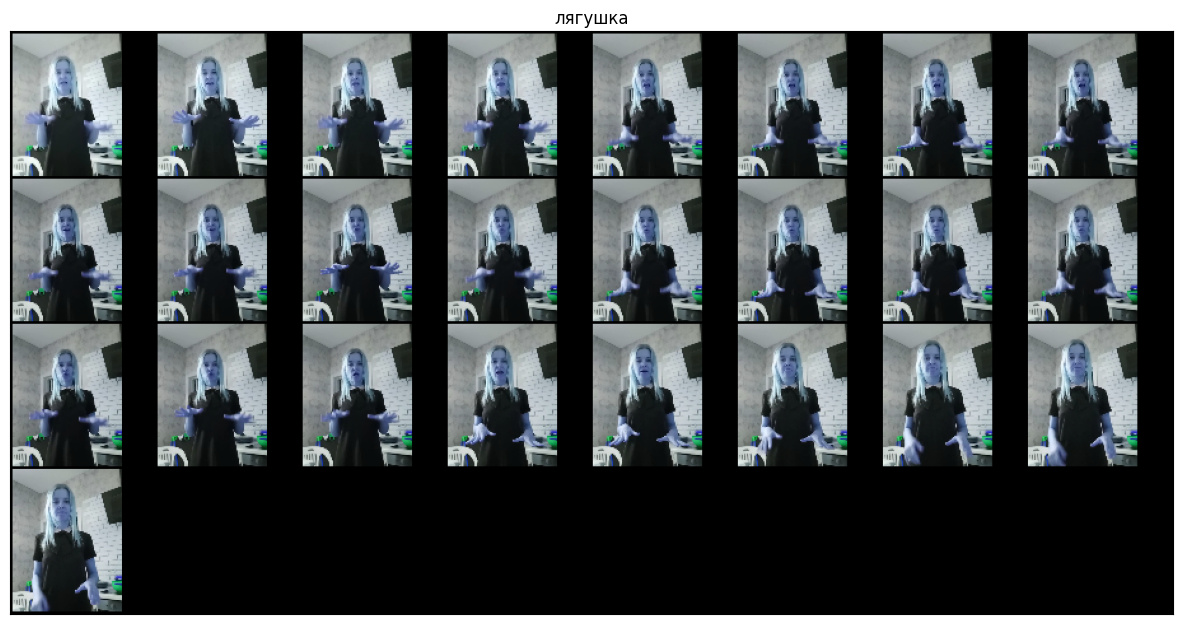

In [14]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [15]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([18])


In [16]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
# for param in resnet.parameters():
#     param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class) # reset out features fir the last layer to the number of classes
resnet.fc

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 70.4MB/s]


Linear(in_features=512, out_features=30, bias=True)

In [18]:
print(resnet)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [17]:
# Print trainable parameters
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Выходные данные были обрезаны до нескольких последних строк (5000).

          [[ 7.5919e-03,  1.4716e-02, -1.3861e-04],
           [-1.2218e-02, -2.5971e-02, -3.4624e-02],
           [-1.8201e-02, -5.0204e-02, -2.3131e-02]]],


         [[[-7.2914e-03,  1.1075e-03, -5.2355e-03],
           [ 1.1578e-02,  3.4235e-03, -9.9431e-03],
           [ 3.5785e-02,  3.0604e-02,  1.4903e-02]],

          [[ 3.4529e-02, -3.5397e-02, -7.1448e-02],
           [ 3.9741e-02, -3.2455e-02, -1.0550e-01],
           [ 7.2960e-02,  1.7431e-02, -5.9923e-02]],

          [[ 1.0390e-02, -4.5598e-02, -9.3849e-02],
           [ 3.0663e-02, -5.5641e-02, -1.2427e-01],
           [ 6.9396e-02, -3.4902e-03, -7.4093e-02]]],


         [[[ 6.2509e-03, -1.0593e-02,  3.4536e-03],
           [-4.0616e-03,  2.8012e-03,  1.5867e-02],
           [ 3.1076e-03, -8.6232e-03,  5.6076e-04]],

          [[ 2.6391e-03, -1.1744e-02, -1.9144e-02],
           [-1.0457e-02, -5.3847e-03, -1.8362e-02],
           [-1.4563e-02, -2.9658e

In [19]:
frames, labels = next(iter(val_dataloader))
frames = frames.to(device)
resnet.to(device)
print(f"Output shape: {resnet(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 30])


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [21]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 15

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/15: train_loss=3.4762; val acc=0.050
Train Epoch 2/15: train_loss=3.4121; val acc=0.067
Train Epoch 3/15: train_loss=2.7896; val acc=0.450
Train Epoch 4/15: train_loss=0.9787; val acc=0.567
Train Epoch 5/15: train_loss=0.2051; val acc=0.667
Train Epoch 6/15: train_loss=0.2045; val acc=0.600
Train Epoch 7/15: train_loss=0.0553; val acc=0.717
Train Epoch 8/15: train_loss=0.0029; val acc=0.767
Train Epoch 9/15: train_loss=0.0012; val acc=0.767
Train Epoch 10/15: train_loss=0.0007; val acc=0.750
Train Epoch 11/15: train_loss=0.0005; val acc=0.750
Train Epoch 12/15: train_loss=0.0003; val acc=0.750
Train Epoch 13/15: train_loss=0.0002; val acc=0.750
Train Epoch 14/15: train_loss=0.0002; val acc=0.750
Train Epoch 15/15: train_loss=0.0001; val acc=0.750


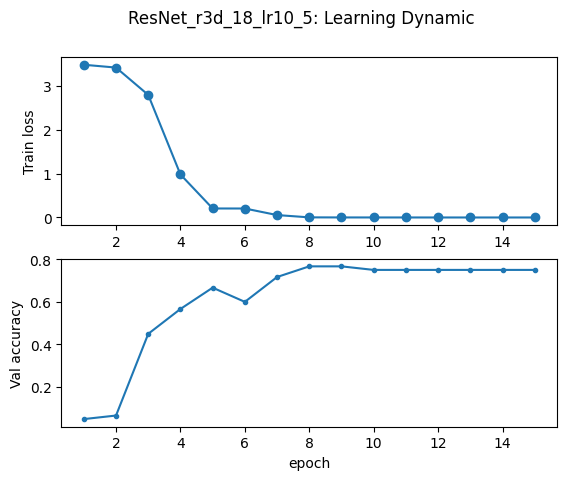

In [22]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [23]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')